### 1D-CNN Demo

In [1]:
import os
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

from src.one_d_cnn import *
from src.one_d_transformer import *
from src.mlp import *
from src.one_d_attention import *

import sklearn
import pickle

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"

In [ ]:
random.seed(1234)
torch.manual_seed(1234)

#### Model Flag

In [4]:
# MODEL_FLAG = 'cnn'
# MODEL_FLAG = 'transformer'
# MODEL_FLAG = 'mlp'
# MODEL_FLAG = 'attention'
MODEL_FLAG = 'resnet'

In [5]:
pretrain = False

#### ResNet

In [6]:
if MODEL_FLAG == 'resnet':
    from torchvision.models import resnet18, ResNet18_Weights

    if pretrain:
        model = resnet18(weights="IMAGENET1K_V2")
    else:
        model = resnet18(weights=None)

In [7]:
#add another fully connected layer to convert output (1,1000) to (1)
class GaModel(nn.Module):
    def __init__(self, pretrain_model):
        super().__init__()
        self.pretrained_model = pretrain_model # delete the last fc layer.
        self.regression = nn.Linear(1000, 1)


    def forward(self, x):
        # input size of x (b, 3, 256, 256) where b is the batch size
        x = self.pretrained_model(x) #output size (b, 1000)
        x = nn.ReLU()(x)
        x = self.regression(x) #output size (1)

        return x

In [8]:
model = GaModel(model)

In [9]:
model

GaModel(
  (pretrained_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

##### Test Model

In [10]:
# batch, seq, feature
src = torch.rand(16, 3, 256, 256)

In [11]:
model = model.to(device)
src = src.to(device)
out = model(src)
print(out.shape)

torch.Size([16, 1])


### Dataset

In [12]:
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from sklearn.model_selection import train_test_split
from src.custom_dataset import RadiomicDataset
from sklearn.model_selection import KFold

In [13]:
TR_TRANSFORMS = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomRotation(degrees=(-15, 15)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

VAL_TRANSFORMS = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [14]:
root_dir = '/mnt/storage/fangyijie/radiomics_ga'

df_dir = root_dir + '/ga_data'
img_dir = root_dir + '/img_data'

In [15]:
X_train = pd.read_pickle(os.path.join(df_dir, 'X_train.pkl'))
y_train = pd.read_pickle(os.path.join(df_dir, 'y_train.pkl'))

X_test = pd.read_pickle(os.path.join(df_dir, 'X_test.pkl'))
y_test = pd.read_pickle(os.path.join(df_dir, 'y_test.pkl'))

Datasets

In [16]:
from src.dataset.fetal_us import fetalhead_2d

In [17]:
train_data = fetalhead_2d(root_dir=root_dir+'/img_data', 
    df1=X_train, df2=y_train, 
    train=True, 
    transform=TR_TRANSFORMS
)

In [18]:
len(train_data)

1783

In [19]:
for image, label in train_data:
    print(image.shape)
    print(label)
    break

torch.Size([3, 256, 256])
tensor([139.9810])


Data Loader

In [20]:
batchsize = 8

In [21]:
# Define data loaders for training and testing data in this fold
train_dataloader = DataLoader(train_data, batch_size=batchsize, shuffle=True)
# train_dataloader = DataLoader(train_data, batch_size=batchsize, shuffle=True)

In [ ]:
for X, y in train_dataloader:
        print("Shape of X: ", X.shape, X.dtype)
        # Output: Shape of X:  torch.Size([1, 1, 543]) torch.float64
        print("Shape of y: ", y.shape, y.dtype)
        break

### Training

In [24]:
import tqdm

In [25]:
num_epochs = 50
lr = 0.0001
# lr = 0.0001 # MLP
criterion = nn.MSELoss() # MSE loss

In [26]:
len(train_dataloader)

223

In [27]:
# GA
if MODEL_FLAG == 'cnn':
    log_dir = root_dir + '/logs/ga/1d_cnn'

if MODEL_FLAG == 'transformer':
    log_dir = root_dir + '/logs/ga/1d_transformer'

if MODEL_FLAG == 'mlp':
    log_dir = root_dir + '/logs/ga/mlp'

if MODEL_FLAG == 'attention':
    log_dir = root_dir + '/logs/ga/attention'

if MODEL_FLAG == 'resnet':
    log_dir = root_dir + '/logs/ga/resnet'

log_dir

'/mnt/storage/fangyijie/radiomics_ga/logs/ga/resnet'

In [28]:
# Initialize optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-8)
# optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [30]:
model = model.to(device)

losses_train: list = []
losses_val: list = []
tr_size = len(train_dataloader)
# val_size = len(val_dataloader)

for epoch in range(0, num_epochs):
    print(f"Epoch {epoch + 1}\n----------------------------")
    tr_loss = 0
    model.train()
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)

        # Compute the prediction error
        pred = model(X)
        # print(y)
        # print(pred)
        # loss = criterion(pred, y) # MSE
        loss = torch.sqrt(criterion(pred, y)) # RMSE

        # break
        
        # Reset the gradient to 0 after each epoch
        optimizer.zero_grad()

        # Compute the backpropagation (back propagate the loss and add one step to the optimizer)
        loss.backward()
        optimizer.step()

        loss = loss.item()
        tr_loss += loss

    print(f"training loss: {tr_loss/tr_size:>7f}")
    losses_train.append(tr_loss/tr_size)

    # validation
    # num_batches = len(val_dataloader)
    # val_loss = 0
    # model.eval()

    # with torch.no_grad():
    #     for X, y in val_dataloader:
    #         X, y = X.to(device), y.to(device)
    #         pred = model(X)
    #         loss = torch.sqrt(criterion(pred, y)).item() # RMSE
    #         # loss = criterion(pred, y).item() # MSE
    #         val_loss += loss
    #         # break
    # losses_val.append(val_loss/val_size)
    # print(f"Validation loss: {val_loss/val_size:>8f} \n")

# save loss locally
with open(f'{log_dir}/{fold}_train_loss.obj', 'wb') as fp:
    pickle.dump(losses_train, fp)

# with open(f'{log_dir}/{fold}_val_loss.obj', 'wb') as fp:
#     pickle.dump(losses_val, fp)

Epoch 1
----------------------------


/home/fangyijie/miniconda3/envs/mamba/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


KeyboardInterrupt: 

#### Following code is not needed when k-fold validation is enabled.

In [30]:
# model = model.to(device)
# losses_train: list = []
# losses_val: list = []
# tr_size = len(train_dataloader.dataset)
# val_size = len(val_dataloader.dataset)

# for epoch in range(0, num_epochs):
#     print(f"Epoch {epoch + 1}\n----------------------------")
#     tr_loss = 0
#     model.train()
#     for batch, (X, y) in enumerate(train_dataloader):
#         X, y = X.to(device), y.to(device)

#         # Compute the prediction error
#         pred = model(X)
#         loss = torch.sqrt(criterion(pred, y)) # RMSE
#         # loss = criterion(pred, y) # MSE
        
#         # Reset the gradient to 0 after each epoch
#         optimizer.zero_grad()

#         # Compute the backpropagation (back propagate the loss and add one step to the optimizer)
#         loss.backward()
#         optimizer.step()

#         loss = loss.item()
#         tr_loss += loss

#         if batch % 100 == 0:
#             print(f"training loss: {tr_loss/tr_size:>7f}")
        
#     losses_train.append(tr_loss/tr_size)

#     # validation
#     num_batches = len(val_dataloader)
#     val_loss = 0
#     model.eval()

#     with torch.no_grad():
#         for X, y in val_dataloader:
#             X, y = X.to(device), y.to(device)
#             pred = model(X)
#             loss = torch.sqrt(criterion(pred, y)).item() # RMSE
#             # loss = criterion(pred, y).item() # MSE
#             val_loss += loss
#     losses_val.append(val_loss/val_size)
#     print(f"Validation loss: {val_loss/val_size:>8f} \n")

### Plotting RMSE

In [31]:
import matplotlib.pyplot as plt

Plot the last k-fold training loss and validation loss

In [32]:
axis_x = np.arange(0, len(losses_train), 1, dtype=int)
axis_y = losses_train

axis_val_x = np.arange(0, len(losses_val), 1, dtype=int)
axis_val_y = losses_val

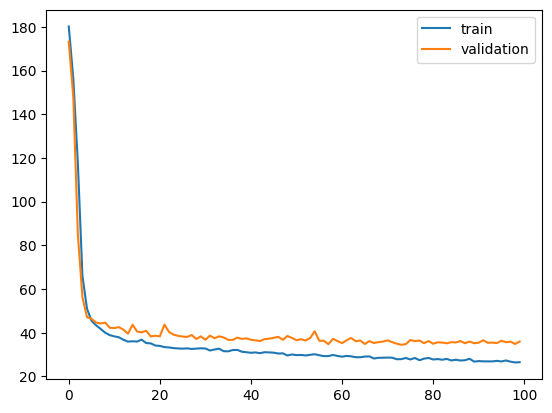

In [33]:
# Plot the chart
plt.plot(axis_x, axis_y, label="train")
plt.plot(axis_val_x, axis_val_y, label="validation")
plt.legend(loc="upper right")
plt.show()  # display

### Test

Following codes are not needed if k-fold validation is enabled.

In [34]:
test_X_array = X_test.iloc[:, :-1].to_numpy()
test_y_array = y_test.to_numpy()

In [35]:
test_X_array = scaler.transform(test_X_array)

In [36]:
test_data = RadiomicDataset(test_X_array, test_y_array)

In [37]:
test_dataloader = DataLoader(test_data, batch_size=batchsize, shuffle=True)

In [38]:
test_size = len(test_dataloader)
num_batches = len(test_dataloader)
test_loss = 0
model.eval()

with torch.no_grad():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = torch.sqrt(criterion(pred, y)).item()
        # loss = criterion(pred, y).item()
        test_loss += loss
print(f"Test loss: {test_loss/test_size:>8f} \n")

Test loss: 36.419410 



In [39]:
# model.eval()
# with torch.no_grad():
#     for X, y in test_dataloader:
#         X, y = X.to(device), y.to(device)
#         pred = model(X)
#         print(torch.squeeze(pred))
#         print(torch.squeeze(y))
#         break

#### Single Case Testing

In [39]:
import random
ind = random.sample(range(0, len(test_X_array)), 20)
# ind = random.randint(0, len(test_X_array))

In [40]:
for i in ind:
    single_test = torch.tensor(test_X_array[i]).unsqueeze(0).float()
    single_test = single_test.unsqueeze(1)
    single_y_pred = model(single_test.to(device))
    # single_y_pred.item()
    single_y = test_y_array[i]

    print(f'Image:  {X_test.iloc[i,-1]}')
    print(f'Y:      {single_y}')
    print(f'Pred_Y: {single_y_pred.item()}')
    print('-'*50)

Image:  Patient00713_Plane3_4_of_4.png
Y:      208.7171928
Pred_Y: 193.452880859375
--------------------------------------------------
Image:  358_HC.png
Y:      138.7664598
Pred_Y: 93.44202423095703
--------------------------------------------------
Image:  372_HC.png
Y:      140.0331919
Pred_Y: 116.88724517822266
--------------------------------------------------
Image:  133_2HC.png
Y:      98.97632485
Pred_Y: 135.3134002685547
--------------------------------------------------
Image:  Patient01048_Plane3_1_of_1.png
Y:      152.370088
Pred_Y: 185.22068786621094
--------------------------------------------------
Image:  529_HC.png
Y:      140.7641374
Pred_Y: 173.9601287841797
--------------------------------------------------
Image:  Patient01209_Plane3_1_of_7.png
Y:      162.7116183
Pred_Y: 145.47232055664062
--------------------------------------------------
Image:  Patient00896_Plane3_1_of_3.png
Y:      142.5998953
Pred_Y: 140.92779541015625
----------------------------------------